# Stiffness Matrix of 3D 8-Node Linear Hexahedral Finite Element

In [1]:
import numpy as np
import sympy as sp
import matplotlib.pyplot as plt
import pandas as pd

from mpl_toolkits.mplot3d.art3d import Poly3DCollection
from tqdm import tqdm

## 0. Determine the Degree of Polynomial for Gauss Quadrature¶

In [2]:
from sympy.abc import *
from sympy import *
"""
Initialize coordinate system
"""
# Define the natural coordinates
xi, eta, zeta = sp.symbols('xi eta zeta')

# Define the global coordinates of the nodes (example values)
nodes_physical = np.array([
    [ 0, 0, 0],
    [ 2, 0, 0],
    [ 2, 2, 0],
    [ 0, 2, 0],
    [ 0, 0, 20],
    [ 2, 0, 20],
    [ 2, 2, 20],
    [ 0, 2, 20]])

"""
Define the shape functions for the 8-node element in terms of natural coordinates
"""
N = [
    (1/8)*(1 - xi)*(1 - eta)*(1 - zeta),
    (1/8)*(1 + xi)*(1 - eta)*(1 - zeta),
    (1/8)*(1 + xi)*(1 + eta)*(1 - zeta),
    (1/8)*(1 - xi)*(1 + eta)*(1 - zeta),
    (1/8)*(1 - xi)*(1 - eta)*(1 + zeta),
    (1/8)*(1 + xi)*(1 - eta)*(1 + zeta),
    (1/8)*(1 + xi)*(1 + eta)*(1 + zeta),
    (1/8)*(1 - xi)*(1 + eta)*(1 + zeta)
]

# Symbolically compute the derivatives of the shape functions
dN_dxi = [sp.diff(N[i], xi) for i in range(8)]
dN_deta = [sp.diff(N[i], eta) for i in range(8)]
dN_dzeta = [sp.diff(N[i], zeta) for i in range(8)]

# Compute the physical coordinates in terms of natural coordinates
x = sum(N[i] * nodes_physical[i, 0] for i in range(8))
y = sum(N[i] * nodes_physical[i, 1] for i in range(8))
z = sum(N[i] * nodes_physical[i, 2] for i in range(8))


"""
Construct Jacobian matrix
"""
J = sp.Matrix([
    [sp.diff(x, xi), sp.diff(x, eta), sp.diff(x, zeta)],
    [sp.diff(y, xi), sp.diff(y, eta), sp.diff(y, zeta)],
    [sp.diff(z, xi), sp.diff(z, eta), sp.diff(z, zeta)]
])

J_inv_T = J.inv().T
J_det = J.det()

"""
Construct B matrix
"""
B1 = sp.Matrix([
        [1, 0, 0, 0, 0, 0, 0, 0, 0],
        [0, 0, 0, 0, 1, 0, 0, 0, 0],
        [0, 0, 0, 0, 0, 0, 0, 0, 1],
        [0, 1, 0, 1, 0, 0, 0, 0, 0],
        [0, 0, 1, 0, 0, 0, 1, 0, 0],
        [0, 0, 0, 0, 0, 1, 0, 1, 0]
    ]) # 6x9

B2 = sp.Matrix([
    [J_inv_T[0,0], J_inv_T[0,1], J_inv_T[0,2], 0, 0, 0, 0, 0, 0],
    [J_inv_T[1,0], J_inv_T[1,1], J_inv_T[1,2], 0, 0, 0, 0, 0, 0],
    [J_inv_T[2,0], J_inv_T[2,1], J_inv_T[2,2], 0, 0, 0, 0, 0, 0],
    [0, 0, 0, J_inv_T[0,0], J_inv_T[0,1], J_inv_T[0,2], 0, 0, 0],
    [0, 0, 0, J_inv_T[1,0], J_inv_T[1,1], J_inv_T[1,2], 0, 0, 0],
    [0, 0, 0, J_inv_T[2,0], J_inv_T[2,1], J_inv_T[2,2], 0, 0, 0],
    [0, 0, 0, 0, 0, 0, J_inv_T[0,0], J_inv_T[0,1], J_inv_T[0,2]],
    [0, 0, 0, 0, 0, 0, J_inv_T[1,0], J_inv_T[1,1], J_inv_T[1,2]],
    [0, 0, 0, 0, 0, 0, J_inv_T[2,0], J_inv_T[2,1], J_inv_T[2,2]]
]) # 9x9

B3 = sp.zeros(9, 24) # 9x24
for i in range(8):
    B3[0, 3*i] = dN_dxi[i]
    B3[1, 3*i] = dN_deta[i]
    B3[2, 3*i] = dN_dzeta[i]

    B3[3, 3*i+1] = dN_dxi[i]
    B3[4, 3*i+1] = dN_deta[i]
    B3[5, 3*i+1] = dN_dzeta[i]

    B3[6, 3*i+2] = dN_dxi[i]
    B3[7, 3*i+2] = dN_deta[i]
    B3[8, 3*i+2] = dN_dzeta[i]

B = B1*B2*B3 # 6x24
B_T = B.T

"""
Constitutive matrix
"""
# Material properties
E = 71e9  # Young's modulus in Pa
nu = 0.33   # Poisson's ratio

# Constitutive matrix for isotropic material (3D case)
D = E / ((1 + nu)*(1 - 2*nu)) * np.array([
    [1 - nu, nu, nu, 0, 0, 0],
    [nu, 1 - nu, nu, 0, 0, 0],
    [nu, nu, 1 - nu, 0, 0, 0],
    [0, 0, 0, (1 - 2*nu)/2, 0, 0],
    [0, 0, 0, 0, (1 - 2*nu)/2, 0],
    [0, 0, 0, 0, 0, (1 - 2*nu)/2]
])

func = B_T*D*B*J_det
poly = Poly(func[0,0])
print(f'Degree of polynomial: {poly.total_degree()}')
poly

Degree of polynomial: 4


Poly(41705827.0676692*eta**2*xi**2 - 83411654.1353383*eta**2*xi + 16437002432.552*eta**2*zeta**2 - 32874004865.1039*eta**2*zeta + 16478708259.6196*eta**2 - 83411654.1353383*eta*xi**2 + 166823308.270677*eta*xi - 32874004865.1039*eta*zeta**2 + 65748009730.2079*eta*zeta - 32957416519.2393*eta + 4170582706.76692*xi**2*zeta**2 - 8341165413.53383*xi**2*zeta + 4212288533.83459*xi**2 - 8341165413.53383*xi*zeta**2 + 16682330827.0677*xi*zeta - 8424577067.66917*xi + 20607585139.3189*zeta**2 - 41215170278.6378*zeta + 20649290966.3866, eta, xi, zeta, domain='RR')

## 1. Define Physical Node Coordinates and Natural Node Coordinates

In [2]:
# Define the global coordinates of the nodes (example values)
nodes_physical = sp.Matrix([
    [0, 0, 0],
    [2, 0, 0],
    [2, 2, 0],
    [0, 2, 0],
    [0, 0, 20],
    [2, 0, 20],
    [2, 2, 20],
    [0, 2, 20]
])

# Define the natural (local) coordinates of the nodes (example values)
nodes_natural = np.array([
    [-1, -1, -1], [1, -1, -1], [1, 1, -1], [-1, 1, -1],
    [-1, -1, 1], [1, -1, 1], [1, 1, 1], [-1, 1, 1]
])

## 2. Define Shape Functions and Derivatives

In [3]:
# Define the natural coordinates
xi, eta, zeta = sp.symbols('xi eta zeta')

# Define the shape functions for the 8-node element in terms of natural coordinates
N = [
    (1/8)*(1 - xi)*(1 - eta)*(1 - zeta),
    (1/8)*(1 + xi)*(1 - eta)*(1 - zeta),
    (1/8)*(1 + xi)*(1 + eta)*(1 - zeta),
    (1/8)*(1 - xi)*(1 + eta)*(1 - zeta),
    (1/8)*(1 - xi)*(1 - eta)*(1 + zeta),
    (1/8)*(1 + xi)*(1 - eta)*(1 + zeta),
    (1/8)*(1 + xi)*(1 + eta)*(1 + zeta),
    (1/8)*(1 - xi)*(1 + eta)*(1 + zeta)
]

# Symbolically compute the derivatives of the shape functions
dN_dxi = [sp.diff(N[i], xi) for i in range(8)]
dN_deta = [sp.diff(N[i], eta) for i in range(8)]
dN_dzeta = [sp.diff(N[i], zeta) for i in range(8)]

# Convert symbolic derivatives to numerical functions
dN_dxi_func = [sp.lambdify((xi, eta, zeta), dN_dxi[i]) for i in range(8)]
dN_deta_func = [sp.lambdify((xi, eta, zeta), dN_deta[i]) for i in range(8)]
dN_dzeta_func = [sp.lambdify((xi, eta, zeta), dN_dzeta[i]) for i in range(8)]

# # Visualize a sample of differentiation of shape function
# dN_deta[0]

## 3. Construct Jacobian Matrix

In [4]:
def construct_Jacobian_matrix(xi1,eta1,zeta1,nodes_physical):
    # Compute the physical coordinates in terms of natural coordinates
    x = sum(N[i] * nodes_physical[i, 0] for i in range(8))
    y = sum(N[i] * nodes_physical[i, 1] for i in range(8))
    z = sum(N[i] * nodes_physical[i, 2] for i in range(8))

    J_exp = sp.Matrix([
        [sp.diff(x, xi), sp.diff(x, eta), sp.diff(x, zeta)],
        [sp.diff(y, xi), sp.diff(y, eta), sp.diff(y, zeta)],
        [sp.diff(z, xi), sp.diff(z, eta), sp.diff(z, zeta)]
    ])
    
    J_func = sp.lambdify((xi,eta,zeta),J_exp,'numpy')
    J = J_func(xi1,eta1,zeta1)

    return J

## 4. Construct B matrix

In [5]:
def construct_B_matrix(xi,eta,zeta,J_inv_T):
    B1 = np.array([
        [1, 0, 0, 0, 0, 0, 0, 0, 0],
        [0, 0, 0, 0, 1, 0, 0, 0, 0],
        [0, 0, 0, 0, 0, 0, 0, 0, 1],
        [0, 1, 0, 1, 0, 0, 0, 0, 0],
        [0, 0, 1, 0, 0, 0, 1, 0, 0],
        [0, 0, 0, 0, 0, 1, 0, 1, 0]
    ]) # 6x9

    B2 = np.array([
        [J_inv_T[0,0], J_inv_T[0,1], J_inv_T[0,2], 0, 0, 0, 0, 0, 0],
        [J_inv_T[1,0], J_inv_T[1,1], J_inv_T[1,2], 0, 0, 0, 0, 0, 0],
        [J_inv_T[2,0], J_inv_T[2,1], J_inv_T[2,2], 0, 0, 0, 0, 0, 0],
        [0, 0, 0, J_inv_T[0,0], J_inv_T[0,1], J_inv_T[0,2], 0, 0, 0],
        [0, 0, 0, J_inv_T[1,0], J_inv_T[1,1], J_inv_T[1,2], 0, 0, 0],
        [0, 0, 0, J_inv_T[2,0], J_inv_T[2,1], J_inv_T[2,2], 0, 0, 0],
        [0, 0, 0, 0, 0, 0, J_inv_T[0,0], J_inv_T[0,1], J_inv_T[0,2]],
        [0, 0, 0, 0, 0, 0, J_inv_T[1,0], J_inv_T[1,1], J_inv_T[1,2]],
        [0, 0, 0, 0, 0, 0, J_inv_T[2,0], J_inv_T[2,1], J_inv_T[2,2]]
    ]) # 9x9

    B3 = np.zeros((9, 24)) # 9x24
    for i in range(8):
        B3[0, 3*i] = dN_dxi_func[i](xi,eta,zeta)
        B3[1, 3*i] = dN_deta_func[i](xi,eta,zeta)
        B3[2, 3*i] = dN_dzeta_func[i](xi,eta,zeta)

        B3[3, 3*i+1] = dN_dxi_func[i](xi,eta,zeta)
        B3[4, 3*i+1] = dN_deta_func[i](xi,eta,zeta)
        B3[5, 3*i+1] = dN_dzeta_func[i](xi,eta,zeta)

        B3[6, 3*i+2] = dN_dxi_func[i](xi,eta,zeta)
        B3[7, 3*i+2] = dN_deta_func[i](xi,eta,zeta)
        B3[8, 3*i+2] = dN_dzeta_func[i](xi,eta,zeta)

    B = B1@B2@B3 # 6x24
    B_T = B.T
    return B, B_T

## 5. Define Material Properties and Constitutive Matrix

In [6]:
# Material properties
E = 71e9  # Young's modulus in Pa
nu = 0.33   # Poisson's ratio

# Constitutive matrix for isotropic material (3D case)
D = E / ((1 + nu)*(1 - 2*nu)) * np.array([
    [1 - nu, nu, nu, 0, 0, 0],
    [nu, 1 - nu, nu, 0, 0, 0],
    [nu, nu, 1 - nu, 0, 0, 0],
    [0, 0, 0, (1 - 2*nu)/2, 0, 0],
    [0, 0, 0, 0, (1 - 2*nu)/2, 0],
    [0, 0, 0, 0, 0, (1 - 2*nu)/2]
])

## 6. Define Gauss Points and Weights

In [7]:
# Define Gauss points and weights for 3-point Gauss quadrature
gauss_points = np.array([-np.sqrt(3/5), 0, np.sqrt(3/5)])
gauss_weights = np.array([5/9, 8/9, 5/9])

In [7]:
gauss_points = np.array([-np.sqrt(3/7-2/7*np.sqrt(6/5)), np.sqrt(3/7-2/7*np.sqrt(6/5)), 
                         -np.sqrt(3/7+2/7*np.sqrt(6/5)), np.sqrt(3/7+2/7*np.sqrt(6/5))])
gauss_weights = np.array([(18+np.sqrt(30))/36, (18+np.sqrt(30))/36, 
                          (18-np.sqrt(30))/36, (18-np.sqrt(30))/36])

## 7. Compute Stiffness Matrix using Gaussian Integration

In [9]:
def compute_stiffness_matrix():
    K_FE = np.zeros((24, 24))
    for i,xi in enumerate(gauss_points):
        for j,eta in enumerate(gauss_points):
            for k,zeta in enumerate(gauss_points):
                J = construct_Jacobian_matrix(xi,eta,zeta,nodes_physical)
                J_inv = np.linalg.inv(J)
                J_inv_T = J_inv.T
                J_det = np.linalg.det(J)
                B, B_T = construct_B_matrix(xi,eta,zeta,J_inv_T)
                w = gauss_weights[i]*gauss_weights[j]*gauss_weights[k]
                K_FE += w * B_T@D@B*J_det
    return K_FE
                
K_FE = compute_stiffness_matrix()
# Convert the matrix to a pandas DataFrame
pd.set_option('display.max_rows', None)
pd.set_option('display.max_columns', None)
df = pd.DataFrame(K_FE)
print("Stiffness Matrix:")
df

Stiffness Matrix:


,0,1,2,3,4,5,6,7,8,9,10,11,12,13,14,15,16,17,18,19,20,21,22,23
0,2.936788e+11,1.308418e+11,1.308418e+10,-2.038166e+11,4.186938e+10,4.186938e+09,-1.463945e+11,-1.308418e+11,2.093469e+09,5.786697e+10,-4.186938e+10,6.542091e+09,1.459497e+11,6.542091e+10,-4.186938e+09,-1.023532e+11,2.093469e+10,-1.308418e+10,-7.341970e+10,-6.542091e+10,-6.542091e+09,2.848862e+10,-2.093469e+10,-2.093469e+09
1,1.308418e+11,2.936788e+11,1.308418e+10,-4.186938e+10,5.786697e+10,6.542091e+09,-1.308418e+11,-1.463945e+11,2.093469e+09,4.186938e+10,-2.038166e+11,4.186938e+09,6.542091e+10,1.459497e+11,-4.186938e+09,-2.093469e+10,2.848862e+10,-2.093469e+09,-6.542091e+10,-7.341970e+10,-6.542091e+09,2.093469e+10,-1.023532e+11,-1.308418e+10
2,1.308418e+10,1.308418e+10,1.209676e+11,-4.186938e+09,6.542091e+09,-2.848862e+10,-2.093469e+09,-2.093469e+09,-5.873053e+10,6.542091e+09,-4.186938e+09,-2.848862e+10,4.186938e+09,4.186938e+09,5.697725e+10,-1.308418e+10,2.093469e+09,-1.599759e+10,-6.542091e+09,-6.542091e+09,-3.024190e+10,2.093469e+09,-1.308418e+10,-1.599759e+10
3,-2.038166e+11,-4.186938e+10,-4.186938e+09,2.936788e+11,-1.308418e+11,-1.308418e+10,5.786697e+10,4.186938e+10,-6.542091e+09,-1.463945e+11,1.308418e+11,-2.093469e+09,-1.023532e+11,-2.093469e+10,1.308418e+10,1.459497e+11,-6.542091e+10,4.186938e+09,2.848862e+10,2.093469e+10,2.093469e+09,-7.341970e+10,6.542091e+10,6.542091e+09
4,4.186938e+10,5.786697e+10,6.542091e+09,-1.308418e+11,2.936788e+11,1.308418e+10,-4.186938e+10,-2.038166e+11,4.186938e+09,1.308418e+11,-1.463945e+11,2.093469e+09,2.093469e+10,2.848862e+10,-2.093469e+09,-6.542091e+10,1.459497e+11,-4.186938e+09,-2.093469e+10,-1.023532e+11,-1.308418e+10,6.542091e+10,-7.341970e+10,-6.542091e+09
5,4.186938e+09,6.542091e+09,-2.848862e+10,-1.308418e+10,1.308418e+10,1.209676e+11,-6.542091e+09,-4.186938e+09,-2.848862e+10,2.093469e+09,-2.093469e+09,-5.873053e+10,1.308418e+10,2.093469e+09,-1.599759e+10,-4.186938e+09,4.186938e+09,5.697725e+10,-2.093469e+09,-1.308418e+10,-1.599759e+10,6.542091e+09,-6.542091e+09,-3.024190e+10
6,-1.463945e+11,-1.308418e+11,-2.093469e+09,5.786697e+10,-4.186938e+10,-6.542091e+09,2.936788e+11,1.308418e+11,-1.308418e+10,-2.038166e+11,4.186938e+10,-4.186938e+09,-7.341970e+10,-6.542091e+10,6.542091e+09,2.848862e+10,-2.093469e+10,2.093469e+09,1.459497e+11,6.542091e+10,4.186938e+09,-1.023532e+11,2.093469e+10,1.308418e+10
7,-1.308418e+11,-1.463945e+11,-2.093469e+09,4.186938e+10,-2.038166e+11,-4.186938e+09,1.308418e+11,2.936788e+11,-1.308418e+10,-4.186938e+10,5.786697e+10,-6.542091e+09,-6.542091e+10,-7.341970e+10,6.542091e+09,2.093469e+10,-1.023532e+11,1.308418e+10,6.542091e+10,1.459497e+11,4.186938e+09,-2.093469e+10,2.848862e+10,2.093469e+09
8,2.093469e+09,2.093469e+09,-5.873053e+10,-6.542091e+09,4.186938e+09,-2.848862e+10,-1.308418e+10,-1.308418e+10,1.209676e+11,4.186938e+09,-6.542091e+09,-2.848862e+10,6.542091e+09,6.542091e+09,-3.024190e+10,-2.093469e+09,1.308418e+10,-1.599759e+10,-4.186938e+09,-4.186938e+09,5.697725e+10,1.308418e+10,-2.093469e+09,-1.599759e+10
9,5.786697e+10,4.186938e+10,6.542091e+09,-1.463945e+11,1.308418e+11,2.093469e+09,-2.038166e+11,-4.186938e+10,4.186938e+09,2.936788e+11,-1.308418e+11,1.308418e+10,2.848862e+10,2.093469e+10,-2.093469e+09,-7.341970e+10,6.542091e+10,-6.542091e+09,-1.023532e+11,-2.093469e+10,-1.308418e+10,1.459497e+11,-6.542091e+10,-4.186938e+09


## 8. Visualization of the Finite Element

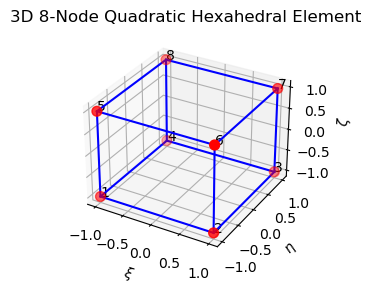

In [39]:
# Visualization of the 3D 8-node quadratic element
fig = plt.figure(figsize=(5,3))
ax = fig.add_subplot(111, projection='3d')

# Plot the nodes
ax.scatter(nodes_natural[:, 0], nodes_natural[:, 1], nodes_natural[:, 2], color='r', s=50)

# Define the edges of the hexahedral element for visualization
edges = [
    [0, 1], [1, 2], [2, 3], [3, 0],   # Bottom face
    [4, 5], [5, 6], [6, 7], [7, 4],  # Top face
    [0, 4], [1, 5], [2, 6], [3, 7]  # Vertical edges
]

# Plot the edges
for edge in edges:
    for i in range(len(edge) - 1):
        x = [nodes_natural[edge[i], 0], nodes_natural[edge[i+1], 0]]
        y = [nodes_natural[edge[i], 1], nodes_natural[edge[i+1], 1]]
        z = [nodes_natural[edge[i], 2], nodes_natural[edge[i+1], 2]]
        ax.plot(x, y, z, 'b-')

# Label the nodes
for i, (x, y, z) in enumerate(nodes_natural):
    ax.text(x, y, z, f'{i+1}', size=10, zorder=1)

# ax.set_xlabel('X')
# ax.set_ylabel('Y')
# ax.set_zlabel('Z')
ax.set_xlabel(r'$\xi$')
ax.set_ylabel(r'$\eta$')
ax.set_zlabel(r'$\zeta$')
ax.set_title('3D 8-Node Quadratic Hexahedral Element')

plt.show()

# Assembly of Stiffness Matrices of All Finite Elements

## 1. Initialize Global Stiffness Matrix

In [8]:
# Number of elements in each direction
num_elements_x = 50
num_elements_y = 50
num_elements_z = 1

# Size of each element in the x, y, and z directions
element_size_x = 2
element_size_y = 2
element_size_z = 20

# Number of nodes in each direction
dof_per_node = 3
num_nodes_x = num_elements_x + 1
num_nodes_y = num_elements_y + 1
num_nodes_z = num_elements_z + 1

# Total number of nodes
num_nodes = num_nodes_x * num_nodes_y * num_nodes_z
size = num_nodes * dof_per_node

# Initialize the global stiffness matrix
K_global = np.zeros((size, size))

# Define the connectivity for each element
def node_index(x, y, z):
    return z * num_nodes_x * num_nodes_y + y * num_nodes_x + x

connectivity = []
for k in range(num_elements_z):
    for j in range(num_elements_y):
        for i in range(num_elements_x):
            n1 = node_index(i, j, k)
            n2 = node_index(i + 1, j, k)
            n3 = node_index(i + 1, j + 1, k)
            n4 = node_index(i, j + 1, k)
            n5 = node_index(i, j, k + 1)
            n6 = node_index(i + 1, j, k + 1)
            n7 = node_index(i + 1, j + 1, k + 1)
            n8 = node_index(i, j + 1, k + 1)
            connectivity.append([n1, n2, n3, n4, n5, n6, n7, n8])

## 2. Assembly of Global Stiffness Matrix

In [9]:
# Assemble the global stiffness matrix
for element in tqdm(connectivity):
    # Node coordinates for the current element
    nodes_physical = np.array([
        [element[0] % num_nodes_x * element_size_x, element[0] // num_nodes_x % num_nodes_y * element_size_y, element[0] // (num_nodes_x * num_nodes_y) * element_size_z],
        [element[1] % num_nodes_x * element_size_x, element[1] // num_nodes_x % num_nodes_y * element_size_y, element[1] // (num_nodes_x * num_nodes_y) * element_size_z],
        [element[2] % num_nodes_x * element_size_x, element[2] // num_nodes_x % num_nodes_y * element_size_y, element[2] // (num_nodes_x * num_nodes_y) * element_size_z],
        [element[3] % num_nodes_x * element_size_x, element[3] // num_nodes_x % num_nodes_y * element_size_y, element[3] // (num_nodes_x * num_nodes_y) * element_size_z],
        [element[4] % num_nodes_x * element_size_x, element[4] // num_nodes_x % num_nodes_y * element_size_y, element[4] // (num_nodes_x * num_nodes_y) * element_size_z],
        [element[5] % num_nodes_x * element_size_x, element[5] // num_nodes_x % num_nodes_y * element_size_y, element[5] // (num_nodes_x * num_nodes_y) * element_size_z],
        [element[6] % num_nodes_x * element_size_x, element[6] // num_nodes_x % num_nodes_y * element_size_y, element[6] // (num_nodes_x * num_nodes_y) * element_size_z],
        [element[7] % num_nodes_x * element_size_x, element[7] // num_nodes_x % num_nodes_y * element_size_y, element[7] // (num_nodes_x * num_nodes_y) * element_size_z]
    ], dtype=float)

    K_FE = compute_stiffness_matrix(nodes_physical)
    
    for i in range(8):  # Loop over local nodes
        for j in range(8):
            global_i = element[i]
            global_j = element[j]
            for k in range(3):  # Loop over DOFs per node
                for l in range(3):
                    GI = 3 * global_i + k
                    GJ = 3 * global_j + l
                    K_global[GI][GJ] += K_FE[3*i + k][3*j + l]
K_global

100%|██████████████████████████████████████████████████████████████████████████████| 2500/2500 [13:32<00:00,  3.08it/s]


array([[2.93678805e+11, 1.30841810e+11, 1.30841810e+10, ...,
        0.00000000e+00, 0.00000000e+00, 0.00000000e+00],
       [1.30841810e+11, 2.93678805e+11, 1.30841810e+10, ...,
        0.00000000e+00, 0.00000000e+00, 0.00000000e+00],
       [1.30841810e+10, 1.30841810e+10, 1.20967615e+11, ...,
        0.00000000e+00, 0.00000000e+00, 0.00000000e+00],
       ...,
       [0.00000000e+00, 0.00000000e+00, 0.00000000e+00, ...,
        2.93678805e+11, 1.30841810e+11, 1.30841810e+10],
       [0.00000000e+00, 0.00000000e+00, 0.00000000e+00, ...,
        1.30841810e+11, 2.93678805e+11, 1.30841810e+10],
       [0.00000000e+00, 0.00000000e+00, 0.00000000e+00, ...,
        1.30841810e+10, 1.30841810e+10, 1.20967615e+11]])

## 3. Visualization of the 50x50x1 Mesh

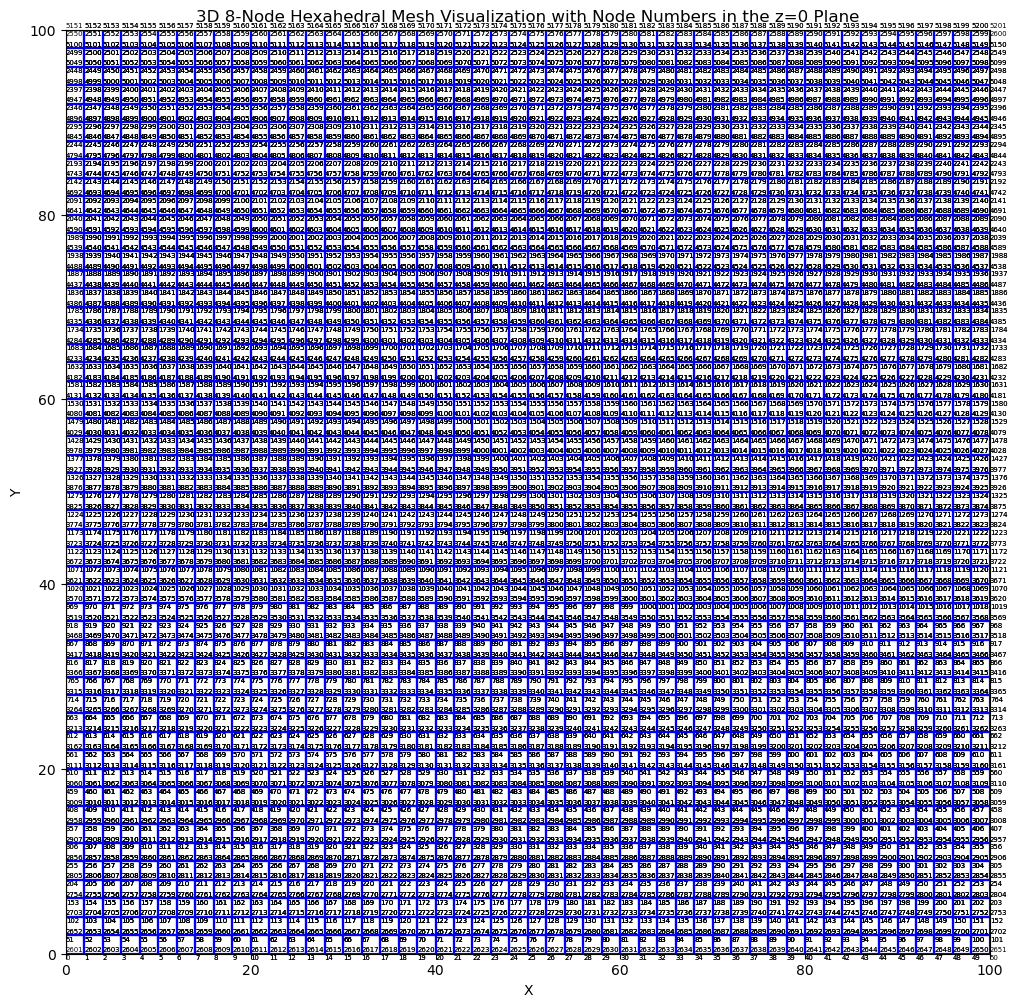

In [17]:
# Create the node grid for visualization
x = np.linspace(0, num_elements_x * element_size_x, num_nodes_x)
y = np.linspace(0, num_elements_y * element_size_y, num_nodes_y)
z = np.linspace(0, num_elements_z * element_size_z, num_nodes_z)

# Create a 3D grid of nodes
X, Y, Z = np.meshgrid(x, y, z, indexing='ij')

# Helper function to compute the global node index from (x, y, z) coordinates
def node_index(x, y, z):
    return z * num_nodes_x * num_nodes_y + y * num_nodes_x + x

# Function to plot a single hexahedral element in 2D plane
def plot_hexahedral(ax, nodes, labels):
    vertices = np.array(nodes)
    edges = [
        [vertices[0], vertices[1]], [vertices[1], vertices[2]], 
        [vertices[2], vertices[3]], [vertices[3], vertices[0]],
        [vertices[4], vertices[5]], [vertices[5], vertices[6]], 
        [vertices[6], vertices[7]], [vertices[7], vertices[4]], 
        [vertices[0], vertices[4]], [vertices[1], vertices[5]], 
        [vertices[2], vertices[6]], [vertices[3], vertices[7]]
    ]
    for edge in edges:
        x = [edge[0][0], edge[1][0]]
        y = [edge[0][1], edge[1][1]]
        ax.plot(x, y, 'b-')
    
    # Add offset to labels to avoid overlap
    offset = 0.1
    for idx, (label, vertex) in enumerate(zip(labels, vertices)):
        if idx < 4:  # Front face
            ax.text(vertex[0], vertex[1] - offset, f'{label}', size=5, zorder=1, color='k', verticalalignment='top')
        else:  # Back face
            ax.text(vertex[0], vertex[1] + offset, f'{label}', size=5, zorder=1, color='k', verticalalignment='bottom')

        
# Plot the mesh for the z = 0 plane
fig, ax = plt.subplots(figsize=(12, 12))

# Plot all elements in the z = 0 plane
k = 0  # z = 0 plane
for i in range(num_elements_x):
    for j in range(num_elements_y):
        element_nodes = [
            [X[i, j, k], Y[i, j, k], Z[i, j, k]],
            [X[i+1, j, k], Y[i+1, j, k], Z[i+1, j, k]],
            [X[i+1, j+1, k], Y[i+1, j+1, k], Z[i+1, j+1, k]],
            [X[i, j+1, k], Y[i, j+1, k], Z[i, j+1, k]],
            [X[i, j, k+1], Y[i, j, k+1], Z[i, j, k+1]],
            [X[i+1, j, k+1], Y[i+1, j, k+1], Z[i+1, j, k+1]],
            [X[i+1, j+1, k+1], Y[i+1, j+1, k+1], Z[i+1, j+1, k+1]],
            [X[i, j+1, k+1], Y[i, j+1, k+1], Z[i, j+1, k+1]]
        ]
        labels = [
            f'{node_index(i, j, k)}',
            f'{node_index(i+1, j, k)}',
            f'{node_index(i+1, j+1, k)}',
            f'{node_index(i, j+1, k)}',
            f'{node_index(i, j, k+1)}',
            f'{node_index(i+1, j, k+1)}',
            f'{node_index(i+1, j+1, k+1)}',
            f'{node_index(i, j+1, k+1)}'
        ]
        plot_hexahedral(ax, element_nodes, labels)

# Set axis limits
ax.set_xlim([0, num_elements_x * element_size_x])
ax.set_ylim([0, num_elements_y * element_size_y])

# Set labels and title
ax.set_xlabel('X')
ax.set_ylabel('Y')
ax.set_title('3D 8-Node Hexahedral Mesh Visualization with Node Numbers in the z=0 Plane')

plt.gca().set_aspect('equal', adjustable='box')
plt.show()